In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

np.set_printoptions(precision=4)

In [50]:
data = pd.read_csv('final_df.csv')

In [51]:
data.head()

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,podium,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1983,1,False,False,True,False,False,keke_rosberg,1,15,...,0,0,0,0,0,0,0,0,0,1
1,1983,1,False,False,True,False,False,prost,2,6,...,0,0,0,1,0,0,0,0,0,0
2,1983,1,False,False,True,False,False,tambay,3,4,...,0,0,0,0,0,0,0,0,0,0
3,1983,1,False,False,True,False,False,piquet,4,1,...,0,0,0,0,0,0,0,0,0,0
4,1983,1,False,False,True,False,False,warwick,5,7,...,0,0,0,0,0,0,0,0,0,0


In [52]:
data.tail()

,season,round,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,podium,...,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
15313,2022,22,True,False,False,False,False,kevin_magnussen,16,17,...,0,0,0,0,0,0,0,0,0,0
15314,2022,22,True,False,False,False,False,gasly,17,14,...,0,0,0,0,0,0,0,0,0,0
15315,2022,22,True,False,False,False,False,bottas,18,15,...,0,0,0,0,0,0,0,0,0,0
15316,2022,22,True,False,False,False,False,albon,19,13,...,0,0,0,0,0,0,0,0,0,1
15317,2022,22,True,False,False,False,False,latifi,20,19,...,0,0,0,0,0,0,0,0,0,1


## Classification

In [53]:
df = data.copy()
df.podium = df.podium.map(lambda x: 1 if x == 1 else 0)

train = df[df.season <2022]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)


In [54]:
# train = X_train.to_csv
# comparison = pd.DataFrame.from_dict(df.podium)
# comparison.to_csv('comparison.csv', index= False)
# comparison = pd.DataFrame(df.podium)
# print(comparison)

In [55]:
def score_classification(model):
    score = 0
    for circuit in df[df.season == 2022]['round'].unique():

        test = df[(df.season == 2022) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium
        
        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
        # make predictions
        prediction_df = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        prediction_df['actual'] = y_test.reset_index(drop = True)
        prediction_df.sort_values('proba_1', ascending = False, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)
        prediction_df.to_csv('prediction_df.csv', index= False)
        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2022]['round'].unique().max()
    return model_score

In [56]:
comparison_dict ={'model':[],
                  'params': [],
                  'score': []}

### Logistic Regression

In [57]:
# Logistic Regression

params={'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
        'C': np.logspace(-3,1,20)}

for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 5000)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
            
            comparison_dict['model'].append('logistic_regression')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)


### Random Forest Classifier

In [58]:
# Random Forest Classifier

params={'criterion': ['gini', 'entropy'],
        'max_features': [0.8, 'auto', None],
        'max_depth': list(np.linspace(5, 55, 26)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth)
            model.fit(X_train, y_train)
            
            model_score = score_classification(model)
            
            comparison_dict['model'].append('random_forest_classifier')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)


### SVM Classifier

In [59]:
# # # Support Vector Machines

# params={'gamma': np.logspace(-4, -1, 27),
#         'C': np.logspace(-2, 1, 27),
#         'kernel': ['linear']} 

# for gamma in params['gamma']:
#     for c in params['C']:
#         for kernel in params['kernel']:
#             model_params = (gamma, c, kernel)
#             model = svm.SVC(probability = True, gamma = gamma, C = c, kernel = kernel )
#             model.fit(X_train, y_train)
            
#             model_score = score_classification(model)
            
#             comparison_dict['model'].append('svm_classifier')
#             comparison_dict['params'].append(model_params)
#             comparison_dict['score'].append(model_score)


### Neural Network Classifier

In [60]:
# Neural network

params={'hidden_layer_sizes': [(80,20,40,5), (75,25,50,10)], 
        'activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'solver': ['sgd', 'adam'], 
        'alpha': np.logspace(-4,2,20)} 


for hidden_layer_sizes in params['hidden_layer_sizes']:
    for activation in params['activation']:
        for solver in params['solver']:
            for alpha in params['alpha']:
                model_params = (hidden_layer_sizes, activation, solver, alpha )
                model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                                      activation = activation, solver = solver, alpha = alpha, random_state = 1)
                model.fit(X_train, y_train)

                model_score = score_classification(model)

                comparison_dict['model'].append('neural_network_classifier')
                comparison_dict['params'].append(model_params)
                comparison_dict['score'].append(model_score)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

## Regression

In [61]:
df = data.copy()

train = df[df.season <2023]
X_train = train.drop(['driver', 'podium'], axis = 1)
y_train = train.podium

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)


In [62]:
def score_regression(model):
    score = 0
    for circuit in df[df.season == 2019]['round'].unique():

        test = df[(df.season == 2019) & (df['round'] == circuit)]
        X_test = test.drop(['driver', 'podium'], axis = 1)
        y_test = test.podium

        #scaling
        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        # make predictions
        prediction_df = pd.DataFrame(model.predict(X_test), columns = ['results'])
        prediction_df['podium'] = y_test.reset_index(drop = True)
        prediction_df['actual'] = prediction_df.podium.map(lambda x: 1 if x == 1 else 0)
        prediction_df.sort_values('results', ascending = True, inplace = True)
        prediction_df.reset_index(inplace = True, drop = True)
        prediction_df['predicted'] = prediction_df.index
        prediction_df['predicted'] = prediction_df.predicted.map(lambda x: 1 if x == 0 else 0)

        score += precision_score(prediction_df.actual, prediction_df.predicted)

    model_score = score / df[df.season == 2019]['round'].unique().max()
    return model_score

### Linear Regression

In [63]:
# Linear Regression

params={'fit_intercept': ['True', 'False']}

for fit_intercept in params['fit_intercept']:
    model_params = (fit_intercept)
    model = LinearRegression(fit_intercept = fit_intercept)
    model.fit(X_train, y_train)
            
    model_score = score_regression(model)
            
    comparison_dict['model'].append('linear_regression')
    comparison_dict['params'].append(model_params)
    comparison_dict['score'].append(model_score)


### Random Forest Regressor

In [64]:
# Random Forest Regressor

params={'criterion': ['mse'],
        'max_features': [0.8, 'auto', None],
        'max_depth': list(np.linspace(5, 55, 26)) + [None]}

for criterion in params['criterion']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestRegressor(criterion = criterion,
                                          max_features = max_features, max_depth = max_depth, random_state = 1)
            model.fit(X_train, y_train)
            
            model_score = score_regression(model)
            
            comparison_dict['model'].append('random_forest_regressor')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:396: FutureWarning: C

### SVM Regressor

In [65]:
## Support Vector Machines

params={'gamma': np.logspace(-4, -1, 10),
        'C': np.logspace(-2, 1, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']} 

for gamma in params['gamma']:
    for c in params['C']:
        for kernel in params['kernel']:
            model_params = (gamma, c, kernel)
            model = svm.SVR(gamma = gamma, C = c, kernel = kernel)
            model.fit(X_train, y_train)
            
            model_score = score_regression(model)
            
            comparison_dict['model'].append('svm_regressor')
            comparison_dict['params'].append(model_params)
            comparison_dict['score'].append(model_score)


### Neural Network Regressor

In [66]:
# Neural network

params={'hidden_layer_sizes': [(80,20,40,5), (75,30,50,10,3)], 
        'activation': ['identity', 'relu','logistic', 'tanh',], 
        'solver': ['lbfgs','sgd', 'adam'], 
        'alpha': np.logspace(-4,1,20)} 

for hidden_layer_sizes in params['hidden_layer_sizes']:
    for activation in params['activation']:
        for solver in params['solver']:
            for alpha in params['alpha']:
                model_params = (hidden_layer_sizes, activation, solver, alpha )
                model = MLPRegressor(hidden_layer_sizes = hidden_layer_sizes,
                                      activation = activation, solver = solver, alpha = alpha, random_state = 1)
                model.fit(X_train, y_train)

                model_score = score_regression(model)

                comparison_dict['model'].append('nn_regressor')
                comparison_dict['params'].append(model_params)
                comparison_dict['score'].append(model_score)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs f

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs f

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochas

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs f

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochas

In [67]:
pd.DataFrame(comparison_dict).groupby('model')['score'].max()

model
linear_regression            0.428571
logistic_regression          0.636364
neural_network_classifier    0.636364
nn_regressor                 0.714286
random_forest_classifier     0.500000
random_forest_regressor      0.904762
svm_regressor                1.000000
Name: score, dtype: float64

In [68]:
df1 = pd.DataFrame.from_dict(comparison_dict).groupby('model')['score'].max()


In [2]:
# df1.head(10)

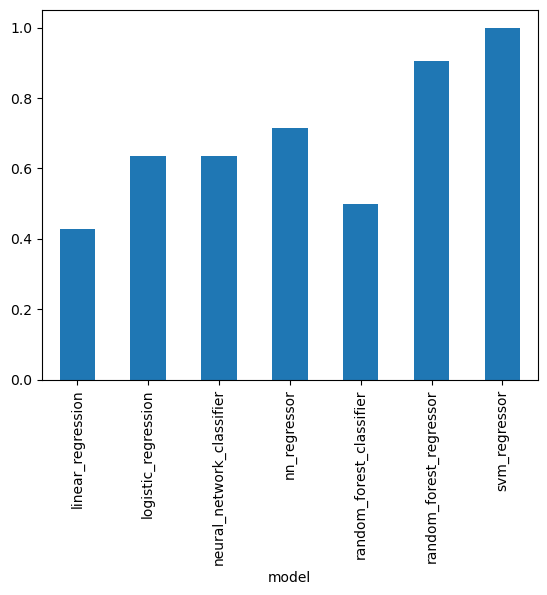

In [80]:
ax = df1.plot.bar(x='model', rot=90)